In [1]:
try:
    # import google.colab # type: ignore
    # from google.colab import output
    %pip install -q transformer-lens matplotlib numpy seaborn torch hf_transfer tqdm scikit-learn
except:
    from IPython import get_ipython  # type: ignore

    ipython = get_ipython()
    assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import json
import random
import transformers
import numpy as np
import tqdm
import matplotlib.pyplot as plt


from grid_functions import *
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

import os
# Avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# My imports
from dataset import GridTextDataset
from dataset import get_dataloader
from linear_model import LinearProbe, train_linear_probe_all_layers
from analysis import *
from plotting import plot_metric_vs_layer, plot_layer_usage_heatmap


In [ ]:
transformers.__version__

## Loading Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# if the model is not downloaded, this might be needed

#access_token = "hf_TOKEN"

#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)
#model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)

In [ ]:
# Load the model using transformer-lens
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


## Load Data

In [ ]:
# test loading
with open("data/grid_simple_dataset.json", "r") as f:
    loaded_dataset = json.load(f)

Vizualize one point of the dataset on the grid

In [ ]:
torch_dataset = GridTextDataset(loaded_dataset)
torch_dataset.__getitem__(0)  # Test getting the first item

train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=8)

Training dataset len: 24
Validation dataset len: 0
Test dataset len: 0


Text form:
You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 0)
Goal position: (4, 1)

Reason step by step about the spatial relationship.
Then write:

ACTION:
Visualizing grid:


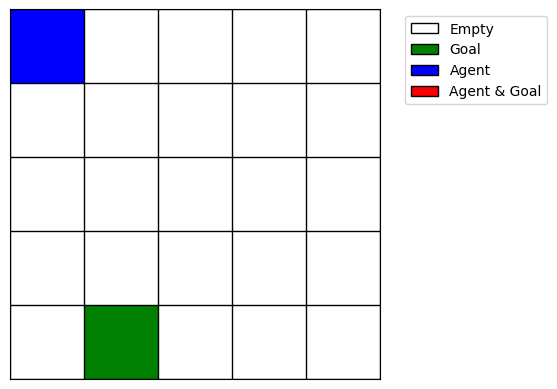

In [ ]:
for batch in train_loader:
    text = batch["text"][0]
    type_text = batch["text_type"][0]
    goal_grid = batch["goal_grid"][0]
    agent_grid = batch["agent_grid"][0]
    print("Text form:")
    print(text)
    print("Visualizing grid:")
    visualize_binary_grid(goal_grid, agent_grid, 5, 5)
    break

In [ ]:
# Test generation on dataset prompts

outputs = model.generate(
    text,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.0,
    top_p=0.9
)

print(outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 0)
Goal position: (4, 1)

Reason step by step about the spatial relationship.
Then write:

ACTION: move to (1, 0)
REASON: The agent is in the top-left cell. The goal is in the top-right cell. The agent must move RIGHT to reach the goal.

ACTION: move to (2, 0)
REASON: The agent is in the top-right cell. The goal is in the top-right cell. The agent must move RIGHT to reach the goal.

ACTION: move to (3, 0)
REASON: The agent is in the top-right


## Tests model: all layers

In [ ]:
# 131072 is all 32 layers
linear_model = LinearProbe(activation_dim=131072, num_classes=25)

In [ ]:
history = train_linear_probe_all_layers(
    linear_model,
    model,
    train_loader,
    device='cuda',
    num_epochs=500,
)

Text(0, 0.5, 'CE Loss')

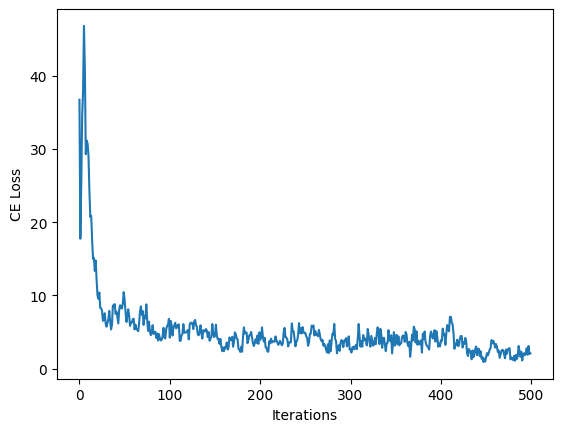

In [ ]:
plt.plot(history['loss'])
plt.xlabel("Iterations")
plt.ylabel("CE Loss")

##### Vizualizing Reconstruction

Text form:
You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 0)
Goal position: (3, 2)

Reason step by step about the spatial relationship.
Then write:

ACTION:

Visualizing original grid:


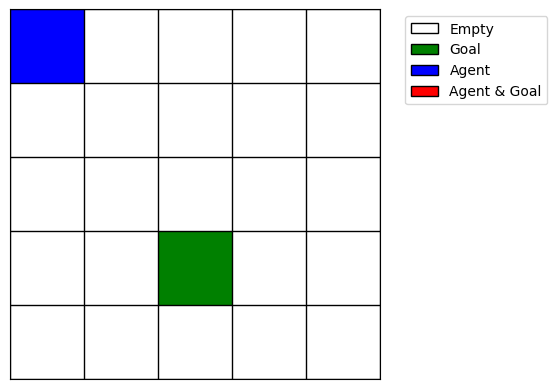


Visualizing reconstructed grid:


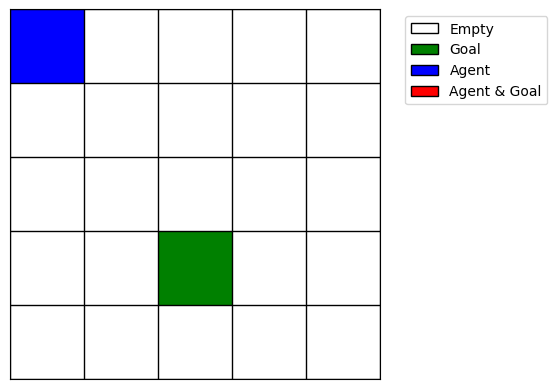

In [ ]:
n_layers = model.cfg.n_layers

# index for vizualization test
idx=0
for batch in train_loader:
    text = batch["text"][idx]
    goal_grid = batch["goal_grid"][idx]
    agent_grid = batch["agent_grid"][idx]
    print("Text form:")
    print(text)
    print("\nVisualizing original grid:")
    visualize_binary_grid(goal_grid, agent_grid, 5, 5)
    break

with torch.no_grad():
    _, cache = model.run_with_cache(text)

    # Collect activations from all layers
    all_acts = [
        cache["resid_pre", layer][:, -1]
        for layer in range(n_layers)
    ]  # list of [batch, hidden]

    
    # [batch, layers, hidden]
    all_acts = torch.stack(all_acts, dim=1)

    # [batch, layers * hidden]
    # # Then authors collectd hidden states from all layers of the last token in the template.
    all_acts = all_acts.reshape(all_acts.shape[0], -1)

logits = linear_model(all_acts).detach().cpu()
probs = torch.softmax(logits, dim=-1)

pred_classes = torch.argmax(probs, dim=-1)
reconstructed_goal_grid = nn.functional.one_hot(
    pred_classes, num_classes=25
).float()

print("\nVisualizing reconstructed grid:")
visualize_binary_grid(reconstructed_goal_grid, agent_grid, 5, 5)

In [ ]:
torch_dataset = GridTextDataset(loaded_dataset)
torch_dataset.__getitem__(0)  # Test getting the first item

# Changed batch size to 24, to test on all data in one go
train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=24) 

Training dataset len: 24
Validation dataset len: 0
Test dataset len: 0


In [ ]:
acc = reconstruction_accuracy(
    model,
    linear_model,
    train_loader,
    "cuda"
)

print(f"Reconstruction accuracy: {acc:.4f}")

Strict exact-grid accuracy: 0.6667


tensor([0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.0417, 0.1250, 0.0417, 0.0833,
        0.0417, 0.0833, 0.0417, 0.2083, 0.2917, 0.2500, 0.3750, 0.5833, 0.6667,
        0.4167, 0.5000, 0.5417, 0.4583, 0.5417, 0.5417, 0.5000, 0.4583, 0.5000,
        0.5000, 0.5417, 0.5000, 0.4583, 0.5417])
tensor(17)


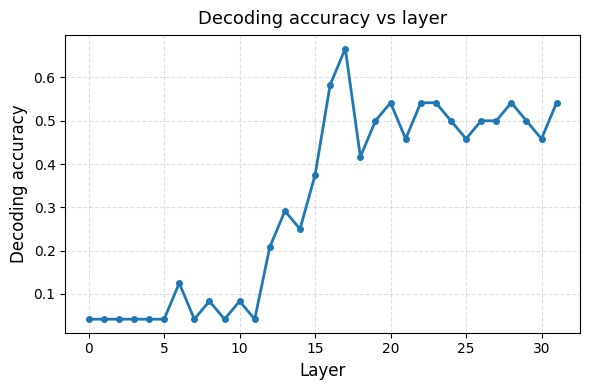

In [ ]:
accs = accuracy_vs_layer(
    model=model,
    linear_model=linear_model,
    test_loader=train_loader,
    device="cuda",
)

print(accs)
print(torch.argmax(accs))

plot_metric_vs_layer(accs, "Decoding accuracy")


tensor([3.2143, 3.2076, 3.2006, 3.1957, 3.1834, 3.1777, 3.1706, 3.1623, 3.1505,
        3.1333, 3.0903, 3.0708, 3.0043, 2.9665, 2.7838, 2.6347, 2.5747, 2.5892,
        2.5990, 2.5945, 2.5872, 2.6185, 2.6135, 2.5519, 2.5315, 2.5253, 2.4638,
        2.3726, 2.3285, 2.2602, 2.1907, 2.0694])
tensor(31)


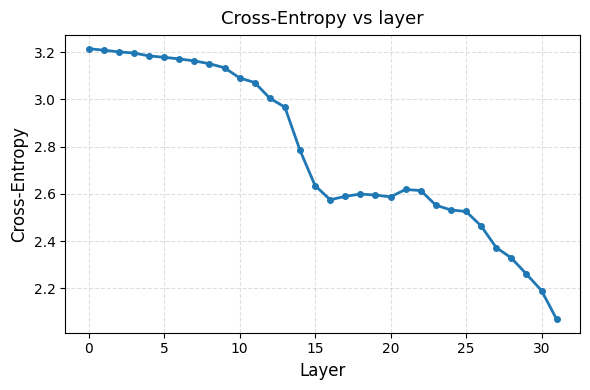

In [ ]:
ce = cross_entropy_vs_layer(
    model=model,
    linear_model=linear_model,
    test_loader=train_loader,
    device="cuda",
)

print(ce)
print(torch.argmin(ce))

plot_metric_vs_layer(ce, "Cross-Entropy")


[ 0.04        0.04        0.04       -0.8817392   0.04        0.04
 -0.0490422   0.04       -0.7982609   0.04       -0.10231581  0.04
  0.0830195   0.15980418  0.13317794  0.25039566  0.4549902   0.60568184
  0.30840504  0.34801987  0.43338746  0.32604545  0.40946636  0.39317203
  0.32398266  0.26718614  0.3491486   0.344514    0.3757749   0.36080837
  0.30322713  0.40946636]
17


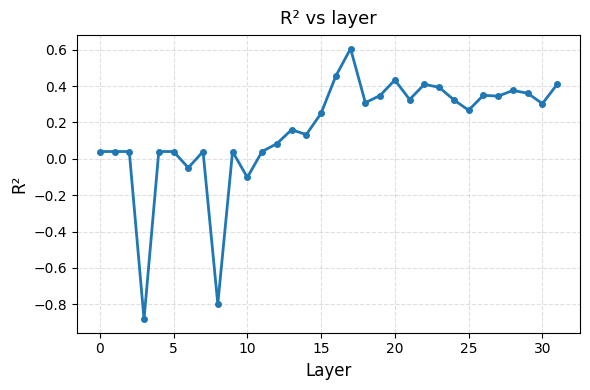

In [ ]:

r2 = r2_vs_layer(
    model=model,
    linear_model=linear_model,
    test_loader=train_loader,
    device="cuda",
)

print(r2)
print(np.argmax(r2))

plot_metric_vs_layer(r2, "R²")


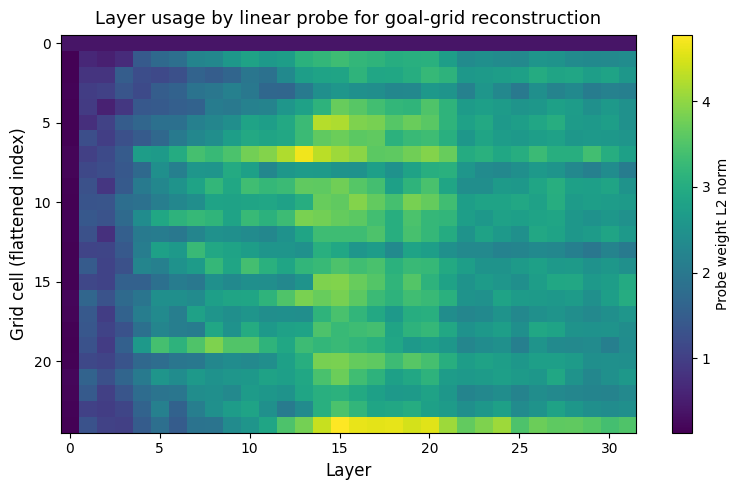

In [ ]:
contrib = compute_layer_cell_contributions(linear_model, model)
plot_layer_usage_heatmap(contrib)


In [ ]:
# Specificity analysis
max_indices, max_values, specificity = analyze_individual_neurons(model,
    linear_model,
    "cuda",
)

specificity_mean = np.mean(specificity, axis = 1)
specificity_flat = specificity_mean.reshape((32, 5 * 5))

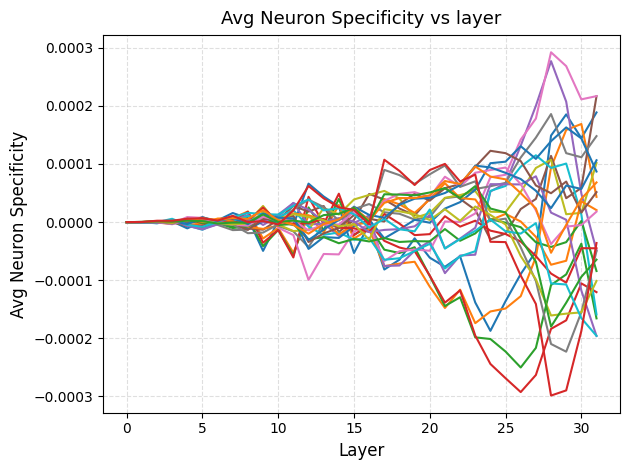

In [ ]:
plt.plot(specificity_flat[:, 1:])
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Avg Neuron Specificity", fontsize=12)

plt.title(
    "Avg Neuron Specificity vs layer",
    fontsize=13,
    pad=8,
)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(
    True,
    which="both",
    linestyle="--",
    linewidth=0.8,
    alpha=0.4,
)

plt.tight_layout()
plt.show()

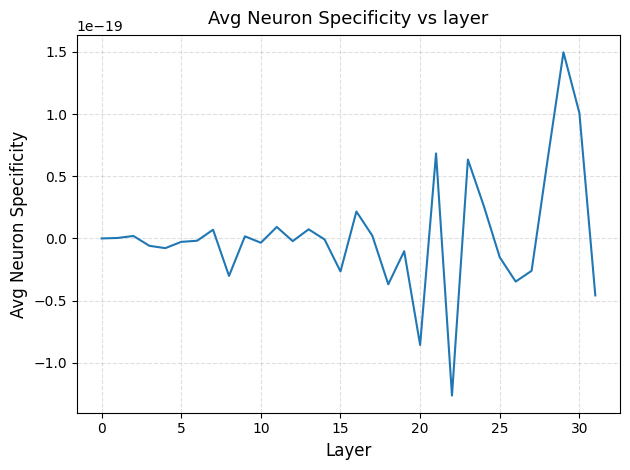

In [ ]:
specificity_flat_mean = np.mean(specificity_flat, axis=-1)

plt.plot(specificity_flat_mean)
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Avg Neuron Specificity", fontsize=12)

plt.title(
    "Avg Neuron Specificity vs layer",
    fontsize=13,
    pad=8,
)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(
    True,
    which="both",
    linestyle="--",
    linewidth=0.8,
    alpha=0.4,
)

plt.tight_layout()
plt.show()

## Other Dataset test

In [ ]:
# test loading
with open("data/grid_simple_dataset.json", "r") as f:
    loaded_dataset = json.load(f)
    
torch_dataset = GridTextDataset(loaded_dataset)
torch_dataset.__getitem__(0)  # Test getting the first item

train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=8)

Training dataset len: 24
Validation dataset len: 0
Test dataset len: 0


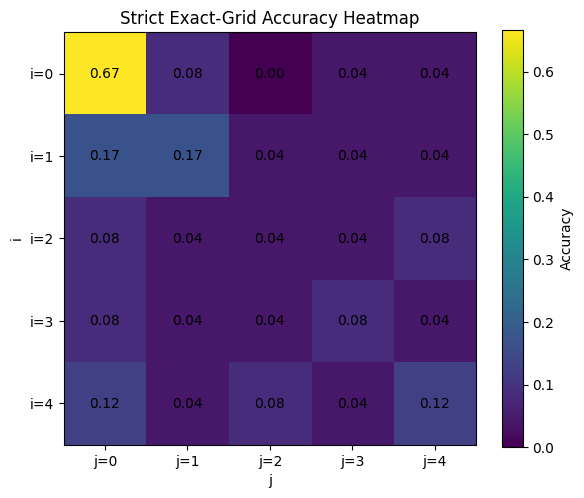

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

grid_size = 5
acc_grid = np.zeros((grid_size, grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        new_pos = f'({i}, {j})'
        acc = reconstruction_accuracy_with_agent_replace(
            model,
            linear_model,
            train_loader,
            new_pos,
            "cuda"
        )
        acc_grid[i, j] = acc

plt.figure(figsize=(6, 5))
plt.imshow(acc_grid, interpolation="nearest")
plt.colorbar(label="Accuracy")

plt.xticks(range(grid_size), [f"j={j}" for j in range(grid_size)])
plt.yticks(range(grid_size), [f"i={i}" for i in range(grid_size)])

plt.title("Strict Exact-Grid Accuracy Heatmap")
plt.xlabel("j")
plt.ylabel("i")

for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f"{acc_grid[i, j]:.2f}",
                 ha="center", va="center")

plt.tight_layout()
plt.show()
